# [IAPR 2019:][iapr2019] Special project

**Group members:**
    1- first name and last name,
    2- first name and last name,
    3- first name and last name

**Due date:** 30.05.2019

[iapr2019]: https://github.com/LTS5/iapr-2019


## Description
Please find the description of this special project via [this link].

[this link]: https://github.com/LTS5/iapr-2019/blob/master/project/special_project_description.pdf

### Module Imports

In [52]:
import tarfile
import os
import skimage.io
import matplotlib.pyplot as plt
import matplotlib.patches as patches

### Extracting data

In [41]:
#extracting tar file

tar_path = os.path.join('./data/', 'project-data.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path='./data/')

### Importing data

In [42]:
data_path = './data/project-data'

#load train images
train_im_path = os.path.join(data_path,'images/train')
im_train_list = [os.path.join(train_im_path,f) for f in os.listdir(train_im_path)\
                 if (os.path.isfile(os.path.join(train_im_path, f)) and f.endswith('.jpg'))]

#load test images
test_im_path = os.path.join(data_path,'images/test')
im_test_list = [os.path.join(test_im_path,f) for f in os.listdir(test_im_path) \
                if (os.path.isfile(os.path.join(test_im_path, f)) and f.endswith('.jpg'))]

#load validation images
validation_im_path = os.path.join(data_path,'images/validation')
im_validation_list = [os.path.join(validation_im_path,f) for f in os.listdir(validation_im_path) \
                      if (os.path.isfile(os.path.join(validation_im_path, f)) and f.endswith('.jpg'))]

im_train = skimage.io.imread_collection(im_train_list)
im_test = skimage.io.imread_collection(im_test_list)
im_val = skimage.io.imread_collection(im_validation_list)



In [43]:
import xml.etree.ElementTree as ET

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

In [44]:
#load train annotations

train_anno_path = os.path.join(data_path,'annotations/train')
anno_train = [parse_file(os.path.join(train_anno_path,f)) for f in os.listdir(train_anno_path)\
                 if (os.path.isfile(os.path.join(train_anno_path, f)) and f.endswith('.xml'))]

#load test annotations
test_anno_path = os.path.join(data_path,'annotations/test')
anno_test = [parse_file(os.path.join(test_anno_path,f)) for f in os.listdir(test_anno_path)\
                 if (os.path.isfile(os.path.join(test_anno_path, f)) and f.endswith('.xml'))]

#loaf validation annotations
validation_anno_path = os.path.join(data_path,'annotations/validation')
anno_val = [parse_file(os.path.join(validation_anno_path,f)) for f in os.listdir(validation_anno_path)\
                 if (os.path.isfile(os.path.join(validation_anno_path, f)) and f.endswith('.xml'))]


In [53]:
def plot_images(images, annotations, names, subplots, figsize=(12, 12), bbox=True):
    '''plotting function'''
    fig, axes = plt.subplots(subplots[0], subplots[1], figsize=figsize)
    for ax, im, nm, annotations in zip(axes.ravel(), images, names, annotations):
        # Iterate over annotations
        if bbox:
            for anno in annotations:
                rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                        linewidth=1,edgecolor='r',facecolor='none')
                ax.add_patch(rect)

        ax.imshow(im)
        ax.axis('off')
        ax.set_title(nm)
    plt.show()
    
    

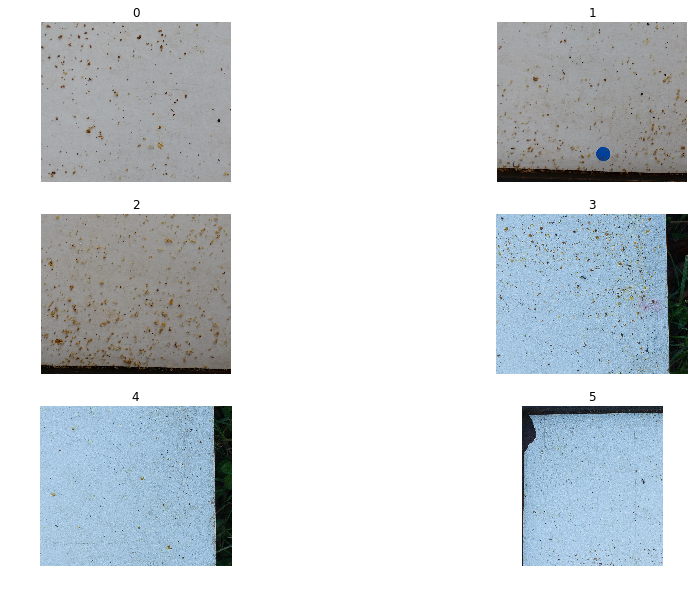

In [57]:
names = [i for i in range(6)]
plot_images(im_train[:6], anno_train[:6], names, [3,2], figsize=(15, 10), bbox=False )


In [60]:
print((im_train[0]).shape)

(1358, 1609, 3)


## Part 1: Finding varroas by segmentation
Add your implementation for ''**detect_by_segmentation**'' function. Please make sure the input and output follows the mentioned format.

In [1]:
def detect_by_segmentation(img):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''

    #Your code

Add your implementation. Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

In [2]:
#Your code

## Part 2: Implement your first detector

Write your function(s) for the second part. Feel free to change the name of the function and add your additional functions, but please make sure their input and output follows the mentioned format.

In [3]:
def detect_by_method_1(img):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''

    #Your code

Add your implementation. Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

In [4]:
#Your code

## Part 3: Using MLP and CNNs

Add your implementation for the thrid part. Feel free to add your desirable functions, but please make sure you have proper functions for the final detection, where their input and output follows the same format as the previous parts.

In [5]:
#Your code

## Challenge

You can generate a json submission file by using the function ''**generate_pred_json**''. This prediction file can be uploaded online for evaluation (Please refer to section 3 of the project description for more details).

In [6]:
import numpy as np
import json

def generate_pred_json(data, tag='baseline'):
    '''
    Input
    - data: Is a dictionary d, such that:
          d = { 
              "ID_1": [], 
              "ID_2": [[x_21, y_21, w_21, h_21], [x_22, y_22, w_22, h_22]], 
              ... 
              "ID_i": [[x_i1, y_i1, w_i1, h_i1], ..., [x_iJ, y_iJ, w_iJ, h_iJ]],
              ... 
              "ID_N": [[x_N1, y_N1, w_N1, h_N1]],
          }
          where ID is the string id of the image (e.i. 5a05e86fa07d56baef59b1cb_32.00px_1) and the value the Kx4 
          array of intergers for the K predicted bounding boxes (e.g. [[170, 120, 15, 15]])
    - tag: (optional) string that will be added to the name of the json file.
    Output
      Create a json file, "prediction_[tag].json", conatining the prediction to EvalAI format.
    '''
    unvalid_key = []
    _data = data.copy()
    for key, value in _data.items():
        try:
            # Try to convert to numpy array and cast as closest int
            print(key)
            v = np.around(np.array(value)).astype(int)
            # Check is it is a 2d array with 4 columns (x,y,w,h)
            if v.ndim != 2 or v.shape[1] != 4:
                unvalid_key.append(key)
            # Id must be a string
            if not isinstance(key, str):
                unvalid_key.append(key)
            _data[key] = v.tolist()
        # Deal with not consistant array size and empty predictions
        except (ValueError, TypeError):
            unvalid_key.append(key)
    # Remove unvalid key from dictionnary
    for key in unvalid_key: del _data[key]
    
    with open('prediction_{}.json'.format(tag), 'w') as outfile:
        json.dump(_data, outfile)

In [7]:
#Your code